In [1]:
import numpy as np
import pandas as pd
import pickle

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import activations
from keras import metrics
from keras import regularizers
import math

import random

from dataset import atti_dirigenti

# to make the experimens replicable
random.seed(123456)

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /home/fabio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/fabio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = atti_dirigenti.load_data(num_words=10000, remove_stopwords=True)

In [3]:
label_index = atti_dirigenti.get_labels()
len(label_index)

20

### Preparing Data

for data and labels

In [4]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [5]:
dimension = 11000

In [7]:
x_train = vectorize_sequences(x_train, dimension)
x_val = vectorize_sequences(x_val, dimension)
x_test = vectorize_sequences(x_test, dimension)

In [8]:
x_train[0:]

array([[ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.]], dtype=float32)

In [9]:
x_train.shape

(99390, 11000)

One hot encoding for the labels

In [10]:
def to_one_hot(labels):
    results = np.zeros((len(labels), len(set(labels))), dtype=np.float16)
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [11]:
y_train = to_one_hot(y_train)
y_val = to_one_hot(y_val)
y_test = to_one_hot(y_test)

In [12]:
y_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float16)

## Build the Models

apart the base model we add new methods with different kind of regularizers. In particular, we take into account:
- l2 that penalize the weights coefficient with a value proportional of their l1 and l2 norms. The general idea is that we prefer a simple model where the distribution of parameters values has less entropy.
- dropout where the idea is to reset randomly a percentage of the weights to zero in order to avoid that neurons start to memorize noise patterns.

In [13]:
def build_model(neurons):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_shape=(x_train.shape[-1], )))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dense(len(label_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [14]:
def build_model_l2(neurons):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(), input_shape=(x_train.shape[-1], )))
    model.add(layers.Dense(neurons, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(layers.Dense(neurons, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(layers.Dense(len(label_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [15]:
def build_model_dropout(neurons):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_shape=(x_train.shape[-1], )))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(label_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [16]:
model_base = build_model(256)

In [17]:
history_base = model_base.fit(x=x_train, y=y_train, validation_data=(x_val, y_val),
                   epochs=10, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 7s 69us/step - loss: 0.8532 - acc: 0.7236 - val_loss: 0.5492 - val_acc: 0.8100
Epoch 2/10
99390/99390 [==============================] - 6s 61us/step - loss: 0.3766 - acc: 0.8669 - val_loss: 0.5189 - val_acc: 0.8247
Epoch 3/10
99390/99390 [==============================] - 6s 61us/step - loss: 0.2510 - acc: 0.9097 - val_loss: 0.5317 - val_acc: 0.8284
Epoch 4/10
99390/99390 [==============================] - 6s 61us/step - loss: 0.1730 - acc: 0.9392 - val_loss: 0.5781 - val_acc: 0.8358
Epoch 5/10
99390/99390 [==============================] - 6s 62us/step - loss: 0.1258 - acc: 0.9568 - val_loss: 0.6297 - val_acc: 0.8328
Epoch 6/10
99390/99390 [==============================] - 6s 62us/step - loss: 0.0967 - acc: 0.9669 - val_loss: 0.6707 - val_acc: 0.8332
Epoch 7/10
99390/99390 [==============================] - 6s 61us/step - loss: 0.0804 - acc: 0.9731 - val_loss: 0.6981 - val_acc

In [18]:
model_l2 = build_model_l2(256)

In [19]:
history_l2 = model_l2.fit(x=x_train, y=y_train, validation_data=(x_val, y_val),
                   epochs=10, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 7s 66us/step - loss: 1.6725 - acc: 0.6546 - val_loss: 1.3757 - val_acc: 0.7274
Epoch 2/10
99390/99390 [==============================] - 6s 63us/step - loss: 1.3489 - acc: 0.7370 - val_loss: 1.3305 - val_acc: 0.7493
Epoch 3/10
99390/99390 [==============================] - 6s 63us/step - loss: 1.2838 - acc: 0.7598 - val_loss: 1.2641 - val_acc: 0.7591
Epoch 4/10
99390/99390 [==============================] - 6s 63us/step - loss: 1.2195 - acc: 0.7742 - val_loss: 1.2243 - val_acc: 0.7724
Epoch 5/10
99390/99390 [==============================] - 6s 63us/step - loss: 1.1620 - acc: 0.7874 - val_loss: 1.1681 - val_acc: 0.7870
Epoch 6/10
99390/99390 [==============================] - 6s 63us/step - loss: 1.1031 - acc: 0.7985 - val_loss: 1.1461 - val_acc: 0.7879
Epoch 7/10
99390/99390 [==============================] - 6s 63us/step - loss: 1.0638 - acc: 0.8053 - val_loss: 1.0991 - val_acc

In [20]:
model_dropout = build_model_dropout(256)

In [21]:
history_dropout = model_dropout.fit(x=x_train, y=y_train, validation_data=(x_val, y_val),
                   epochs=10, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 7s 65us/step - loss: 1.2965 - acc: 0.5907 - val_loss: 0.6065 - val_acc: 0.7944
Epoch 2/10
99390/99390 [==============================] - 6s 57us/step - loss: 0.6266 - acc: 0.7927 - val_loss: 0.5215 - val_acc: 0.8212
Epoch 3/10
99390/99390 [==============================] - 6s 57us/step - loss: 0.4866 - acc: 0.8352 - val_loss: 0.4928 - val_acc: 0.8288
Epoch 4/10
99390/99390 [==============================] - 6s 56us/step - loss: 0.4100 - acc: 0.8604 - val_loss: 0.4927 - val_acc: 0.8337
Epoch 5/10
99390/99390 [==============================] - 6s 56us/step - loss: 0.3568 - acc: 0.8778 - val_loss: 0.4929 - val_acc: 0.8387
Epoch 6/10
99390/99390 [==============================] - 6s 56us/step - loss: 0.3140 - acc: 0.8932 - val_loss: 0.4953 - val_acc: 0.8402
Epoch 7/10
99390/99390 [==============================] - 6s 57us/step - loss: 0.2872 - acc: 0.9031 - val_loss: 0.4965 - val_acc

### Printing The Loss

In [22]:
import matplotlib.pyplot as plt

%matplotlib inline

In [23]:
def chart_loss(history, name):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'b+', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss {}'.format(name))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yticks(np.arange(0,2.2, step=0.2))
    plt.xticks(epochs)
    plt.legend()
    plt.show()

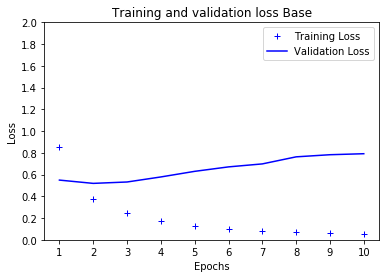

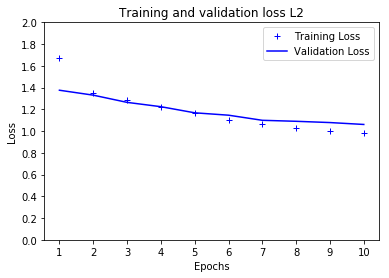

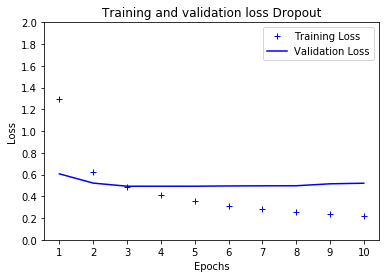

In [24]:
chart_loss(history_base, 'Base')
chart_loss(history_l2, 'L2')
chart_loss(history_dropout, 'Dropout')

From the charts we can see that: 
- the model with l2 regularization is able to avoid overfitting during the training. 
- the model that uses dropout (0.5) has a lower loss with respect to l2 while combatting overfitting

In [25]:
def chart_acc(history, name):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b+', label='Training Acc')
    plt.plot(epochs, val_acc, 'b', label='Validation Acc')
    plt.title('Training and validation acc {}'.format(name))
    plt.xlabel('Epochs')
    plt.ylabel('Accuray')
    plt.yticks(np.arange(0.5,1.05, step=0.05))
    plt.xticks(epochs)
    plt.legend()
    plt.show()

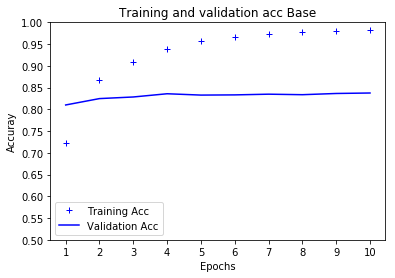

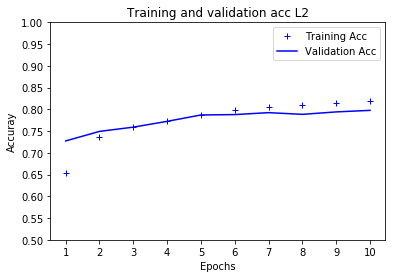

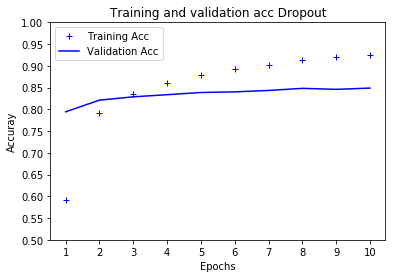

In [26]:
chart_acc(history_base, 'Base')
chart_acc(history_l2, 'L2')
chart_acc(history_dropout, 'Dropout')

From the chart above we can see that the best model is the model that uses dropout, while the best epoch is the 6 where the validation accuracy crosses the training accuracy

In [27]:
def compare_loss(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_loss']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, label='Validation Loss {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

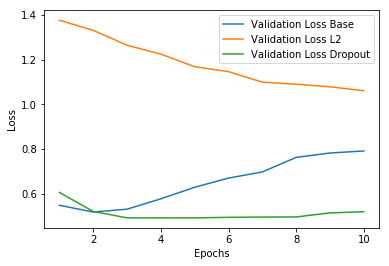

In [28]:
compare_loss({'Base': history_base, 'L2': history_l2, 'Dropout': history_dropout})

In [29]:
def compare_accuracy(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_acc']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_acc']
        plt.plot(epochs, val_loss, label='Validation Accuracy {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

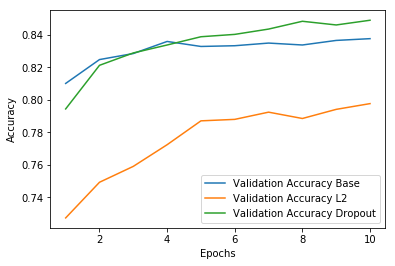

In [30]:
compare_accuracy({'Base': history_base, 'L2': history_l2, 'Dropout': history_dropout})

In [31]:
def min_loss(history):
    val_loss = history.history['val_loss'] 
    return np.argmin(val_loss) + 1   

def accuracy(history, epoch):
    val_acc = history.history['val_acc']
    return val_acc[epoch-1]

In [32]:
print('min loss for model base is {}'.format(min_loss(history_base)))
print('min loss for model L2 is {}'.format(min_loss(history_l2)))
print('min loss for model Dropout is {}'.format(min_loss(history_dropout)))

min loss for model base is 2
min loss for model L2 is 10
min loss for model Dropout is 4


In [33]:
print('best validation accuracy for model base {}'.format(
    accuracy(history_base, min_loss(history_base))))
print('best validation accuracy for model L2 {}'.format(
    accuracy(history_l2, min_loss(history_l2))))
print('best validation accuracy for model Dropout {}'.format(
    accuracy(history_dropout, min_loss(history_dropout))))

best validation accuracy for model base 0.8247011952622997
best validation accuracy for model L2 0.7976276712199994
best validation accuracy for model Dropout 0.8336653386238303


### Evaluate on the Test Set

- train the best model for the best epochs

In [34]:
import gc
gc.collect()

16413

In [40]:
model = build_model_dropout(256)

In [41]:
history = model.fit(x=np.concatenate([x_train, x_val]), y=np.concatenate([y_train, y_val]), epochs=6, batch_size=256)

Epoch 1/6
110434/110434 [==============================] - 7s 64us/step - loss: 1.2402 - acc: 0.6046
Epoch 2/6
110434/110434 [==============================] - 7s 61us/step - loss: 0.6156 - acc: 0.7942
Epoch 3/6
110434/110434 [==============================] - 7s 61us/step - loss: 0.4837 - acc: 0.8365
Epoch 4/6
110434/110434 [==============================] - 7s 61us/step - loss: 0.4078 - acc: 0.8617
Epoch 5/6
110434/110434 [==============================] - 7s 62us/step - loss: 0.3544 - acc: 0.8795
Epoch 6/6
110434/110434 [==============================] - 7s 62us/step - loss: 0.3175 - acc: 0.8919


In [42]:
loss, acc = model.evaluate(x_test, y_test)

27609/27609 [==============================] - 1s 48us/step


In [43]:
print('loss {}'.format(loss))
print('acc {}'.format(acc))

loss 0.47449750354329817
acc 0.843529283939948


## Conclusion

As recap we can see that using regularization, in particular dropout, the accuracy grows from 0.83 to 0.84.